**Excersize 2:**

**1.1.1 Transfer Learning from ImageNet**

- Download and prepare CIFAR-10 dataset

- Use AlexNet as the model (Pytorch AlexNet)

    - Train the model for CIFAR-10 data, Report the test test accuracy. (also referred as fine tuning the model)
    - Use the pretarined weights of AlexNet for image classification on CIFAR-10 data (also referred as Feature Extraction).
    - Report the accuracy on the test set

- In both the above cases remember to add an extra fully connected layer to the classifier with number of neurons = 10, because there are 10 classes in CIFAR-10 dataset. This layer will be trainable in both the cases.

**1.1.2 Transfer Learning from MNIST**

- Prepare a CNN of your choice and train it on the MNIST data. Report the accuracy.

- Use the above model as a pretrained CNN for the SVHN dataset. Report the accuracy.

- In the third step you are performing transfer learining from MNIST to SVHN.

In [ ]:
import os
import re
import copy
import time
import glob
import shutil
import pickle
import tarfile
import zipfile
import datetime
import subprocess
import numpy as np
import pandas as pd
import urllib.request
import seaborn as sns
from PIL import Image
from copy import deepcopy
from tqdm.auto import tqdm
from tabulate import tabulate
from google.colab import drive
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision.datasets import CIFAR10
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from torchvision.models import AlexNet, AlexNet_Weights
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, classification_report
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
%load_ext tensorboard

In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

# Set the project folder
#project_folder = '/content/drive/MyDrive/D7047E/'
mount_point = '/content/drive/'
data_folder = '/content/data'

src_file = 'cifar-10-python.tar.gz'
#src_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

if not os.path.exists(mount_point):
    drive.mount(mount_point)
else:
    print(f"Drive is already mounted at {mount_point}")

os.chdir(os.path.join(mount_point))

# Delete existing data folders
if os.path.exists(data_folder):
    shutil.rmtree(data_folder)

if os.path.exists(os.path.join(mount_point,'/cifar-10')):
    shutil.rmtree(os.path.join(mount_point,'/cifar-10'))

if os.path.exists(os.path.join(mount_point,'/cifar-10-batches-py')):
    shutil.rmtree(os.path.join(mount_point,'/cifar-10-batches-py'))

# Create the data folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Create the 'project' folder on Google Drive if it doesn't exist
project_folder = os.path.join(mount_point, 'MyDrive/D7047E/')
if not os.path.exists(project_folder):
    os.makedirs(project_folder)
    print(f"\nProject folder created at {project_folder}")

# Create the 'accuracy' folder in the project folder on Google Drive if it doesn't exist
accuracy_folder = os.path.join(mount_point, project_folder, 'accuracy')
if not os.path.exists(accuracy_folder):
    os.makedirs(accuracy_folder)
    print(f"\naccuracy folder created at {accuracy_folder}")

# Create the 'softmax' folder in the project folder on Google Drive if it doesn't exist
softmax_folder = os.path.join(mount_point, project_folder, 'softmax')
if not os.path.exists(softmax_folder):
    os.makedirs(softmax_folder)
    print(f"\nsoftmax folder created at {softmax_folder}")

# Create the 'logs' folder in the project folder on Google Drive if it doesn't exist
logs_folder = os.path.join(mount_point, project_folder, 'logs')
if not os.path.exists(logs_folder):
    os.makedirs(logs_folder)
    print(f"\nlogs folder created at {logs_folder}")

# Create the 'checkpoints' folder in the project folder on Google Drive if it doesn't exist
checkpoint_folder = os.path.join(mount_point, project_folder, 'checkpoint')
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)
    print(f"\nCheckpoints folder created at {checkpoint_folder}")


os.chdir('/content/')

if not os.path.exists(data_folder):
    num_files = 0
else:
    num_files = 0
    for root, dirs, files in os.walk(data_folder):
        num_files += len(files)

print(f'\nThere are {num_files} files in the destination folder: {data_folder}\n')


# Download and extract CIFAR-10 dataset
class customCIFAR10(CIFAR10):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        img_path = self.data[index]
        return img, target, img_path

# Data transforms
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # CIFAR-10
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))# CIFAR-10
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))# CIFAR-10
    ]),
    'visualization': transforms.Compose([
        transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) # ImageNet
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))# CIFAR-10
    ])
}

trainset = datasets.CIFAR10(root=data_folder, train=True, download=True, transform=transforms['train'])
testset = customCIFAR10(root=data_folder, train=False, download=True, transform=transforms['test'])

class_names = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

# Rename the extracted folder from cifar-10-batches-py to cifar-10
if os.path.exists(os.path.join(data_folder, 'cifar-10-batches-py')):
    os.rename(os.path.join(data_folder, 'cifar-10-batches-py'), os.path.join(data_folder, 'cifar-10'))

# Remove the downloaded tar.gz file
if os.path.exists(os.path.join(data_folder, src_file)):
    os.remove(os.path.join(data_folder, src_file))

print("\nCIFAR-10 dataset downloaded and extracted successfully.")

# Split trainset into validation and training using stratified sampling
trainset.targets = np.array(trainset.targets)
train_idx, val_idx = train_test_split(np.arange(len(trainset.targets)),
                                  test_size=0.2,
                                  stratify=trainset.targets,
                                  random_state=42)
train_set = Subset(trainset, train_idx)
val_set = Subset(trainset, val_idx)

# Verify splits are disjoint
assert set(train_idx).isdisjoint(set(val_idx)), "There are common elements between the training and validation splits"

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'valid': val_loader, 'test': test_loader}

# Class labels for CIFAR-10 dataset
class_names = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

# Save metrics to pickle files
pickle_files = [
    "all_train_accuracies.pickle",
    "all_train_losses.pickle",
    "all_val_accuracies.pickle",
    "all_val_losses.pickle",
    "all_learning_rates.pickle",]

Mounted at /content/drive/

There are 0 files in the destination folder: /content/data



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified

CIFAR-10 dataset downloaded and extracted successfully.


**CNN model architecture**:


Feature extraction layers (features): This part is a sequence of convolutional, ReLU activation, and max-pooling layers that process the input image and learn to extract relevant features. The layers are as follows:
********************
Convolutional layer (3 input channels, 64 output channels, 11x11 kernel, 4x4 stride, 2x2 padding)

ReLU activation (in-place)

Max-pooling layer (3x3 kernel, 2x2 stride)

Convolutional layer (64 input channels, 192 output channels, 5x5 kernel, 1x1 stride, 2x2 padding)

ReLU activation (in-place)

Max-pooling layer (3x3 kernel, 2x2 stride)

Convolutional layer (192 input channels, 384 output channels, 3x3 kernel, 1x1 stride, 1x1 padding)

ReLU activation (in-place)

Convolutional layer (384 input channels, 256 output channels, 3x3 kernel, 1x1 stride, 1x1 padding)

ReLU activation (in-place)

Convolutional layer (256 input channels, 256 output channels, 3x3 kernel, 1x1 stride, 1x1 padding)

ReLU activation (in-place)

Max-pooling layer (3x3 kernel, 2x2 stride)

Average pooling layer (avgpool): This layer performs adaptive average pooling, reducing the spatial dimensions of the feature maps to a fixed size (6x6 in this case).

Classification layers (classifier): This part is a sequence of fully connected layers, dropout layers, and ReLU activation layers that process the features extracted by the previous layers and output class scores. The layers are as follows:

Dropout layer (probability 0.5)

Fully connected (linear) layer (9216 input features, 4096 output features)
ReLU activation (in-place)

Dropout layer (probability 0.5)

Fully connected (linear) layer (4096 input features, 4096 output features)
ReLU activation (in-place)

Fully connected (linear) layer (4096 input features, 10 output features)
******************************
This specific implementation of AlexNet is designed for a 10-class classification problem, as indicated by the output features of the last linear layer.

In [ ]:
def convert_to_cpu(tensor_list):
    return [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in tensor_list]


def save_dicts_to_files(file_prefix, data_dicts, accuracy_folder):
    for data_dict, file in zip(data_dicts, pickle_files):
        file_name = os.path.join(accuracy_folder, f"{file[:-7]}{file_prefix}.pickle")
        with open(file_name, "wb") as handle:
            converted_dict = {k: [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in v] for k, v in data_dict.items()}
            pickle.dump(converted_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_dicts_from_files(pickle_files, accuracy_folder):
    loaded_dicts = []
    for file in pickle_files:
        file_name = os.path.join(accuracy_folder, file)
        with open(file_name, "rb") as handle:
            data_dict = pickle.load(handle)

            # Convert to CPU
            data_dict_cpu = {k: convert_to_cpu(v) for k, v in data_dict.items()}
            loaded_dicts.append(data_dict_cpu)
    return loaded_dicts


def activation_name(activation_func):
    name = str(activation_func)
    if "Tanh" in name:
        return "Tanh"
    elif "LeakyReLU" in name:
        return "LeakyReLU"
    elif ".ReLU" in name:
        return "ReLU"
    else:
        return name


def latest_checkpoint(checkpoint_folder):
    checkpoint_files = [f for f in os.listdir(checkpoint_folder) if f.endswith('.pth')]
    if not checkpoint_files:
        return None

    # Extract epoch numbers from file names
    epoch_numbers = [int(re.search(r'e(\d+)', f).group(1)) for f in checkpoint_files]

    # Find the file with the highest epoch number
    latest_epoch = max(epoch_numbers)
    latest_checkpoint_file = f'model_checkpoint_e{latest_epoch}.pth'

    return os.path.join(checkpoint_folder, latest_checkpoint_file)


def train_and_evaluate(model_list, criterion, activation_functions, lr, optimizers, epochs, best_val_acc, best_model_params, metric, lr_patience, early_stopping_patience, tensorboard_log, tensorboard_active, saving_frequency, freeze_layers):

    for model_dict in model_list:

        model_name = model_dict["name"]
        model = model_dict["model"]

        best_val_acc = 0.0
        best_model_params = None

        # Initialize dictionaries to store losses and accuracies for each hyperparameter
        all_train_losses = {}
        all_train_accuracies = {}
        all_val_losses = {}
        all_val_accuracies = {}
        all_learning_rates = {}

        data_dicts = [all_train_accuracies, all_train_losses, all_val_accuracies, all_val_losses, all_learning_rates]

        best_model = None

        if tensorboard_active:
            #%tensorboard --logdir {os.path.join(mount_point, project_folder, 'logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))}
            %tensorboard --logdir {os.path.join(mount_point, project_folder, 'logs')}
        if tensorboard_log:
            writer = SummaryWriter(os.path.join(mount_point, project_folder, 'logs', f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

        # Check for the latest checkpoint
        latest_checkpoint_path = latest_checkpoint(os.path.join(mount_point, project_folder, checkpoint_folder))

        start_epoch = 0
        if latest_checkpoint_path:
            user_input = input(f'Latest checkpoint found: {latest_checkpoint_path}. Do you want to resume training from this epoch? (y/n): ')

            if user_input.lower() == 'y':
                checkpoint = torch.load(latest_checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])

                # Get the optimizer type from the checkpoint
                optimizer_type = checkpoint['optimizer_type']

                # Initialize the optimizer using the optimizer type from the checkpoint
                optimizer = optimizers[optimizer_type](model.parameters(), lr=lr)
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                best_val_metric = checkpoint['best_val_metric']

        for opt in optimizers:

            for af in activation_functions:

                # Create a new model for each hyperparameter combination
                num_features = model.classifier[6].in_features
                model.classifier[6] = nn.Linear(num_features, len(class_names))
                model = model.to(device)

                # Freeze layers (except the fully-connected)
                if freeze_layers:
                    for name, param in model.named_parameters():
                        if "fc" not in name:
                            param.requires_grad = False


                # Initialize the model and criterion
                initial_model_state = deepcopy(model.state_dict())
                initial_criterion = deepcopy(criterion)

                # Reset the model and criterion to their initial states
                model.load_state_dict(deepcopy(initial_model_state))
                criterion = deepcopy(initial_criterion)

                # Initialize the optimizer based on the selected type
                if opt == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                elif opt == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                print(f'\n\n\nTraining model {model_name} with learning rate: {lr}, optimizer: {opt} and activation function: {activation_name(af)} \n\n')

                # Initialize the learning rate scheduler
                scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=lr_patience, verbose=True)

                # Initialize lists to store loss and accuracy values
                train_losses = []
                train_accuracies = []
                val_losses = []
                val_accuracies = []
                learning_rates = []

                # Define early stopping parameters
                epochs_since_best = 0
                best_val_metric = None

                for epoch in range(epochs):
                    print(f'Epoch {epoch + 1}/{epochs}')
                    print('-' * 10)

                    hp = f'{model_name}_{lr}_{opt}_{activation_name(af)}_{epoch + 1}'

                    for phase in ['train', 'valid']:
                        if phase == 'train':
                            model.train()
                        else:
                            model.eval()

                        running_loss = 0.0
                        running_corrects = 0
                        num_samples = 0

                        progress_bar = tqdm(dataloaders[phase], desc=f'{phase} progress')
                        for inputs, labels in progress_bar:
                            inputs = inputs.to(device)
                            labels = labels.to(device)
                            optimizer.zero_grad()

                            # Forward pass and calculate the loss
                            with torch.set_grad_enabled(phase == 'train'):
                                outputs = model(inputs)
                                _, preds = torch.max(outputs, 1)
                                loss = criterion(outputs, labels)

                                # Backward pass and optimize the weights
                                if phase == 'train':
                                    loss.backward()
                                    optimizer.step()

                            running_loss += loss.item() * inputs.size(0)
                            running_corrects += torch.sum(preds == labels.data)
                            num_samples += inputs.size(0)

                            # Update the progress bar
                            progress_bar.set_postfix(loss=loss.item(), acc=running_corrects.double() / num_samples, refresh=True)

                        epoch_loss = running_loss / num_samples
                        epoch_acc = running_corrects.double() / num_samples

                        print(f'                      loss: {epoch_loss:.4f} accuracy: {epoch_acc * 100:.2f}%')

                        if phase == 'train':
                            train_losses.append(epoch_loss)
                            train_accuracies.append(epoch_acc)
                            lr = optimizer.param_groups[0]['lr']
                            learning_rates.append(lr)

                            # Tensorboard
                            if tensorboard_log:
                                writer.add_scalar(f'Training loss_{hp}', epoch_loss, epoch)
                                writer.add_scalar(f'Training accuracy_{hp}', epoch_acc, epoch)

                        else:
                            val_losses.append(epoch_loss)
                            val_accuracies.append(epoch_acc)

                            # Tensorboard
                            if tensorboard_log:
                                writer.add_scalar(f'Validation loss_{hp}', epoch_loss, epoch)
                                writer.add_scalar(f'Validation accuracy_{hp}', epoch_acc, epoch)

                            # Update the learning rate based on the validation accuracy
                            scheduler.step(epoch_acc)

                            # Save the current learning rate
                            lr = optimizer.param_groups[0]['lr']
                            learning_rates.append(lr)

                            # Save the current model state every 'x' epochs
                            if (epoch + 1) % saving_frequency == 0:
                                model_save_name = f'model_checkpoint_e{epoch+1}.pth'
                                model_save_path = os.path.join(mount_point, project_folder, checkpoint_folder, model_save_name)
                                print(f'\nSaving checkpoint for epoch {epoch+1} at {model_save_path}\n')
                                torch.save({
                                    'epoch': epoch,
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'scheduler_state_dict': scheduler.state_dict(),
                                    'best_val_metric': best_val_metric,
                                    'optimizer_type': opt,
                                    'model_name': model_name
                                }, model_save_path)

                                checkpoint_paths = sorted(glob.glob(os.path.join(mount_point, project_folder, checkpoint_folder, '*.pth')), key=os.path.getctime)
                                if len(checkpoint_paths) > 2:
                                    for path in checkpoint_paths[:-2]:
                                        os.unlink(path)


                    # Choose the metric based on the 'metric' parameter
                    if metric == 'accuracy':
                        val_metric = epoch_acc
                        mode = 'max'
                    elif metric == 'loss':
                        val_metric = epoch_loss
                        mode = 'min'

                    # Update best validation metric and reset the counter
                    if best_val_metric is None or (mode == 'max' and val_metric > best_val_metric) or (mode == 'min' and val_metric < best_val_metric):
                        best_val_metric = val_metric
                        epochs_since_best = 0
                    else:
                        # Increment the counter if there is no improvement
                        epochs_since_best += 1

                    # Check if early stopping condition is met
                    if epochs_since_best >= early_stopping_patience:
                        print(f"\nEarly stopping triggered at epoch {epoch + 1}. No significant improvement in the validation metric for {early_stopping_patience} epochs.")
                        break


                # Save the losses and accuracies for the current setting
                all_train_losses[hp] = train_losses
                all_train_accuracies[hp] = train_accuracies
                all_val_losses[hp] = val_losses
                all_val_accuracies[hp] = val_accuracies
                all_learning_rates[hp] = learning_rates

                current_val_acc = max(val_accuracies)
                current_val_loss = min(val_losses)
                max_val_acc_epoch = val_accuracies.index(current_val_acc) + 1

                # Update the best model if the current validation accuracy is better
                if current_val_acc > best_val_acc:
                    best_val_acc = current_val_acc
                    rel_val_loss = current_val_loss
                    best_model = model
                    best_model_params = {
                        'lr': lr,
                        'af': {activation_name(af)},
                        'optimizer': opt,
                        'model_state': model.state_dict(),
                        'val_acc_epoch': max_val_acc_epoch  #save the epoch when the best validation accuracy is achieved
                    }

                    table = [["Model", model_name],
                            ["Best Validation Accuracy", f"{best_val_acc * 100:.2f}%"],
                            ["Validation Loss", f"{rel_val_loss:.4f}"],
                            ["Learning Rate", best_model_params["lr"]],
                            ["Optimizer", best_model_params["optimizer"]],
                            ["Activation", activation_name(af)],
                            ["Epoch", best_model_params["val_acc_epoch"]]]

                    print('\n', tabulate(table, tablefmt="simple"))

                    # Hyperparameter information
                    file_name_prefix = f'{model_name}_acc{best_val_acc:.4f}_lr{best_model_params["lr"]}_{best_model_params["optimizer"]}_epoch{best_model_params["val_acc_epoch"]}_{activation_name(af)}'

                    if best_model is not None:
                        # Save the best model with hyperparameter information
                        model_save_name = f'model__{file_name_prefix}.pth'
                        model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                        torch.save(best_model_params['model_state'], model_save_path)
                        print(f'\nBest model saved to {model_save_path}')

                        # Save the best model as 'best_model.pth'
                        model_save_name = f'best_model.pth'
                        model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                        torch.save(best_model_params['model_state'], model_save_path)
                        print(f'\nBest model also saved as "best_model.pth"\n\n')


        # Close TensorBoard writer
        if tensorboard_log:
            writer.close()

        # Save with the prefix
        save_dicts_to_files(file_name_prefix, data_dicts, accuracy_folder)

        # Save to the base files
        save_dicts_to_files('', data_dicts, accuracy_folder)

    return best_model

In [ ]:
# model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizers = {
    'SGD': torch.optim.SGD
}
model_list = [
    #{"name": "AlexNet", "model": models.alexnet()},
    {"name": "AlexNet weights.IMAGENET1K_V1", "model": models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)},
]
activation_functions = [nn.ReLU] # [nn.LeakyReLU, nn.Tanh]
lr = 0.1
epochs = 25

lr_patience = 2 # reduce learning rate by factor 0.1 if the validation performance doesn't improve after 'x' number of epochs
early_stopping_patience = 5 # stop training if the validation performance doesn't improve after 'x' number of epochs
metric = 'accuracy' # to maximize the 'accuracy'
#metric = 'loss'  # to minimize the 'loss'
criterion = nn.CrossEntropyLoss()

best_val_acc = float('-inf')
best_model_params = None
tensorboard_active = False
tensorboard_log = False
saving_frequency = 50
freeze_layers = True

train_and_evaluate(model_list, criterion, activation_functions, lr, optimizers, epochs, best_val_acc, best_model_params, metric, lr_patience, early_stopping_patience, tensorboard_log, tensorboard_active, saving_frequency, freeze_layers)




Training model AlexNet weights.IMAGENET1K_V1 with learning rate: 0.1, optimizer: SGD and activation function: ReLU 


Epoch 1/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 2.3469 accuracy: 10.84%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 2.3380 accuracy: 10.31%
Epoch 2/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 2.3463 accuracy: 10.74%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 2.3369 accuracy: 10.25%
Epoch 3/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 2.3465 accuracy: 10.86%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 2.3407 accuracy: 10.20%
Epoch 4/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 2.3465 accuracy: 10.60%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 2.3389 accuracy: 10.65%
Epoch 5/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 2.3454 accuracy: 10.95%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 2.3389 accuracy: 10.57%

Saving checkpoint for epoch 5 at /content/drive/MyDrive/D7047E/checkpoint/model_checkpoint_e5.pth

Epoch 6/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 2.3450 accuracy: 10.67%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 2.3405 accuracy: 10.30%
Epoch 7/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 2.3456 accuracy: 10.76%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 2.3373 accuracy: 10.42%
Epoch 00007: reducing learning rate of group 0 to 1.0000e-02.
Epoch 8/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 2.3444 accuracy: 10.73%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 2.3399 accuracy: 10.45%
Epoch 9/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 2.3461 accuracy: 10.72%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 2.3404 accuracy: 10.32%

Early stopping triggered at epoch 9. No significant improvement in the validation metric for 5 epochs.

 ------------------------  -----------------------------
Model                     AlexNet weights.IMAGENET1K_V1
Best Validation Accuracy  10.65%
Validation Loss           2.3369
Learning Rate             0.1
Optimizer                 SGD
Activation                ReLU
Epoch                     4
------------------------  -----------------------------

Best model saved to /content/drive/MyDrive/D7047E/model__AlexNet weights.IMAGENET1K_V1_acc0.1065_lr0.1_SGD_epoch4_ReLU.pth

Best model also saved as "best_model.pth"




AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
def plot_metrics():
    time.sleep(5) # eliminating errors related to the delays with Google Drive update after saving the metrics

    # Load the most recently created metrics dictionaries from files and convert them to CPU
    all_train_accuracies_cpu, all_train_losses_cpu, all_val_accuracies_cpu, all_val_losses_cpu, all_learning_rates_cpu = load_dicts_from_files(pickle_files, accuracy_folder)

    fig, axs = plt.subplots(2, 2, figsize=(20, 12))

    # Add a secondary y-axis for learning rates
    axs_lr = [ax.twinx() for ax in axs.flatten()]

    def plot_learning_rates(axs_lr, setting, all_learning_rates_cpu, color, label=None):
        lr_history = all_learning_rates_cpu[setting][:len(accuracies)]
        axs_lr.plot(range(1, len(lr_history) + 1),
                    lr_history,
                    linestyle='-', color=color, linewidth=0.5, alpha=0.75, label=label)

        axs_lr.set_ylabel("Learning Rate", color='gray')
        axs_lr.tick_params(axis='y', colors='gray')
        axs_lr.set_yscale('log')  # log scale for the y-axis
        y_ticks = [0.1, 0.01, 0.001, 0.0001, 0.00001]
        axs_lr.set_yticks(y_ticks)  # Set the y-ticks

        formatter = FuncFormatter(lambda x, pos: f"{x:.0}".rstrip("0").rstrip(".") if x > 0 else "")
        axs_lr.get_yaxis().set_major_formatter(formatter)
        axs_lr.legend(loc='lower right', fontsize='small')

    #xticks = np.arange(1, epochs + 1)
    xticks = np.arange(1, len(all_train_accuracies_cpu.items()) + 1)

    max_train_acc_value = max([max(accuracies) for accuracies in all_train_accuracies_cpu.values()])
    max_train_acc_setting = max(all_train_accuracies_cpu, key=lambda key: max(all_train_accuracies_cpu[key]))
    max_train_acc_epoch = all_train_accuracies_cpu[max_train_acc_setting].index(max_train_acc_value) + 1

    max_val_acc_value = max([max(accuracies) for accuracies in all_val_accuracies_cpu.values()])
    max_val_acc_setting = max(all_val_accuracies_cpu, key=lambda key: max(all_val_accuracies_cpu[key]))
    max_val_acc_epoch = all_val_accuracies_cpu[max_val_acc_setting].index(max_val_acc_value) + 1

    min_train_loss_value = min([min(losses) for losses in all_train_losses_cpu.values()])
    min_train_loss_setting = min(all_train_losses_cpu, key=lambda key: min(all_train_losses_cpu[key]))
    min_train_loss_epoch = all_train_losses_cpu[min_train_loss_setting].index(min_train_loss_value) + 1

    min_val_loss_value = min([min(losses) for losses in all_val_losses_cpu.values()])
    min_val_loss_setting = min(all_val_losses_cpu, key=lambda key: min(all_val_losses_cpu[key]))
    min_val_loss_epoch = all_val_losses_cpu[min_val_loss_setting].index(min_val_loss_value) + 1

    for i, (setting, accuracies) in enumerate(all_train_accuracies_cpu.items()):
        xticks = np.arange(1, len(accuracies) + 1)
        line = axs[0, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        axs[0, 0].set_xticks(xticks[::2])
        axs[0, 0].set_ylim(top=max_train_acc_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[0], setting, all_learning_rates_cpu, color = 'gray', label ='Learning Rate' if i == 0 else None)

    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].set_title("Training Accuracy")
    axs[0, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 0].legend(loc='lower left')

    for i, (setting, losses) in enumerate(all_train_losses_cpu.items()):
        line = axs[0, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        axs[0, 1].set_xticks(xticks[::2])
        axs[0, 1].set_ylim(top=min_train_loss_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[1], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].set_title("Training Loss")
    axs[0, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 1].legend(loc='lower left')

    for i, (setting, accuracies) in enumerate(all_val_accuracies_cpu.items()):
        line = axs[1, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        axs[1, 0].set_xticks(xticks[::2])
        axs[1, 0].set_ylim(top=max_val_acc_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[2], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].set_title(f"Validation Accuracy\n(max: {max_val_acc_value * 100:.2f}% - {max_val_acc_setting} / epoch {max_val_acc_epoch})")
    axs[1, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 0].legend(loc='lower left')

    for i, (setting, losses) in enumerate(all_val_losses_cpu.items()):
        line = axs[1, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        axs[1, 1].set_xticks(xticks[::2])
        axs[1, 1].set_ylim(top=min_val_loss_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[3], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].set_title(f"Validation Loss\n(min: {min_val_loss_value:.4f} - {min_val_loss_setting} / epoch {min_val_loss_epoch})")
    axs[1, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 1].legend(loc='lower left')

    # Add dashed lines for highest achieved accuracy and lowest loss on the best epoch
    axs[0, 0].axhline(y=max_train_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_value * 100:.2f}%')
    axs[0, 0].axvline(x=max_train_acc_epoch , linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_epoch}')

    axs[0, 1].axhline(y=min_train_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {min_train_loss_value}')
    axs[0, 1].axvline(x=min_train_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_train_loss_epoch}')

    axs[1, 0].axhline(y=max_val_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_val_acc_value * 100:.2f}%')
    axs[1, 0].axvline(x=max_val_acc_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy epoch: {max_val_acc_epoch}')

    axs[1, 1].axhline(y=min_val_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss: {min_val_loss_value:.4f}')
    axs[1, 1].axvline(x=min_val_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_val_loss_epoch}')

    plt.show()

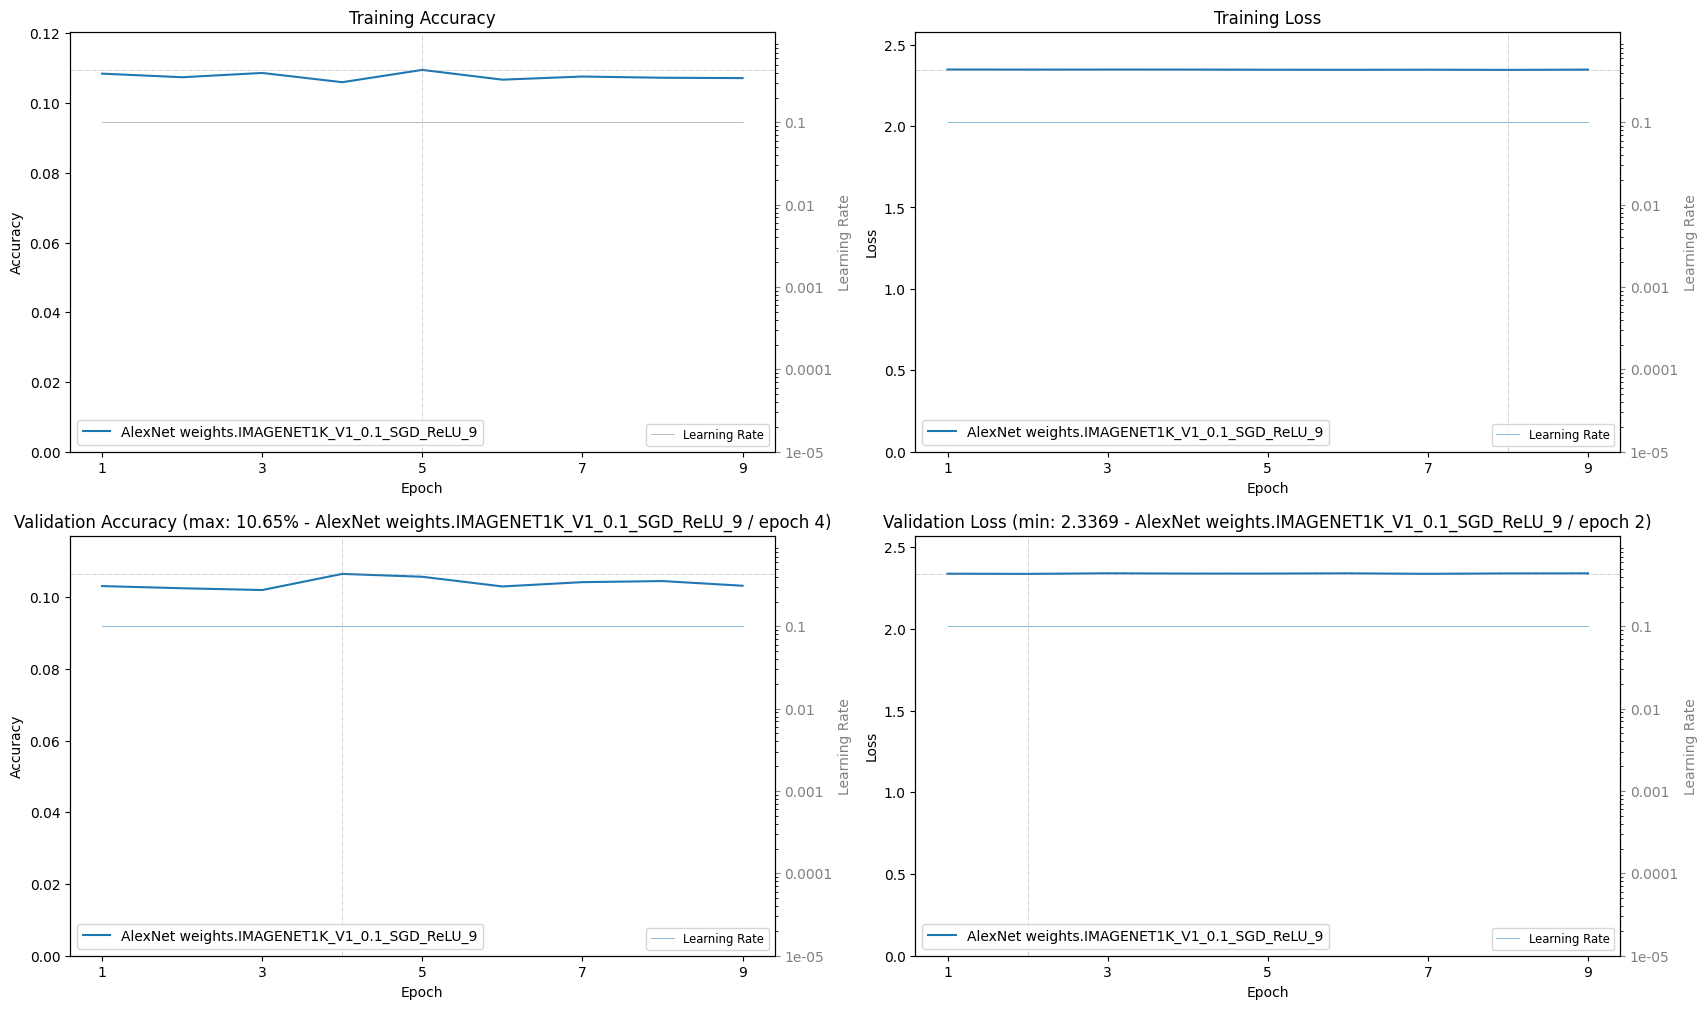

In [ ]:
plot_metrics()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Testing progress:   0%|          | 0/79 [00:00<?, ?it/s]

                           Test accuracy: 11.81%


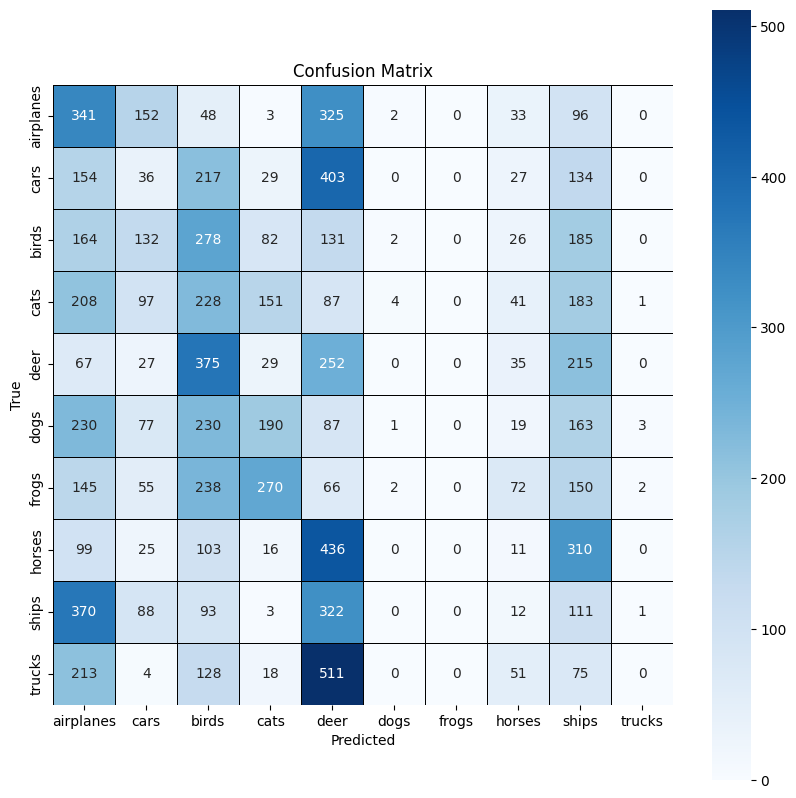

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:

              precision    recall  f1-score   support

   airplanes       0.17      0.34      0.23      1000
        cars       0.05      0.04      0.04      1000
       birds       0.14      0.28      0.19      1000
        cats       0.19      0.15      0.17      1000
        deer       0.10      0.25      0.14      1000
        dogs       0.09      0.00      0.00      1000
       frogs       0.00      0.00      0.00      1000
      horses       0.03      0.01      0.02      1000
       ships       0.07      0.11      0.08      1000
      trucks       0.00      0.00      0.00      1000

    accuracy                           0.12     10000
   macro avg       0.08      0.12      0.09     10000
weighted avg       0.08      0.12      0.09     10000

tensor([[0.1106, 0.0860, 0.0914,  ..., 0.1150, 0.1589, 0.0666],
        [0.1337, 0.1005, 0.1472,  ..., 0.0768, 0.1552, 0.0570],
        [0.1469, 0.1190, 0.1289,  ..., 0.0985, 0.1281, 0.0827],
        ...,
        [0.1

In [ ]:
# Testing the best model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the saved model
model_path = os.path.join(mount_point, project_folder, f'best_model.pth')

# Set the model to evaluation mode
model = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(class_names))
model.eval()

# Load the model weights
if device.type == 'cuda':
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

all_preds = []
all_labels = []

softmax_scores = []
image_names = []

test_progress_bar = tqdm(dataloaders['test'], desc='Testing progress')

for inputs, labels, paths in test_progress_bar:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        softmax = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    softmax_scores.append(softmax.cpu())
    image_names.extend([p.item() for p in paths.flatten()])  # Convert tensor to string and flatten

    # Update progress bar
    test_progress_bar.set_postfix(acc=torch.sum(preds == labels.data))

accuracy = accuracy_score(all_labels, all_preds)
print(f'                           Test accuracy: {accuracy * 100:.2f}%')

softmax_scores = torch.cat(softmax_scores)
#image_names = [os.path.splitext(os.path.basename(p))[0] for p in image_names]

# Plotting confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, linewidths=0.5, linecolor='black', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report:\n')
print(report)

print(softmax_scores)

# Saving softmax scores
softmax_scores_path = os.path.join(mount_point, project_folder, softmax_folder, 'softmax_scores.npy')

if not os.path.exists(softmax_scores_path):
    np.save(softmax_scores_path, softmax_scores)
    print(f'\nSoftmax scores saved to {softmax_scores_path}')
else:
    print(f'\nSoftmax scores already stored in {softmax_scores_path}')

In [ ]:
# Create the 'accuracy' folder in the project folder on Google Drive if it doesn't exist
accuracy_folder = os.path.join(mount_point, project_folder, 'accuracy_3')
if not os.path.exists(accuracy_folder):
    os.makedirs(accuracy_folder)
    print(f"\naccuracy folder created at {accuracy_folder}")


accuracy folder created at /content/drive/MyDrive/D7047E/accuracy_3


In [ ]:
# model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizers = {
    'SGD': torch.optim.SGD
}
model_list = [
    #{"name": "AlexNet", "model": models.alexnet()},
    {"name": "AlexNet weights.IMAGENET1K_V1", "model": models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)},
]
activation_functions = [nn.ReLU] # [nn.LeakyReLU, nn.Tanh]
lr = 0.01
epochs = 25

lr_patience = 2 # reduce learning rate by factor 0.1 if the validation performance doesn't improve after 'x' number of epochs
early_stopping_patience = 5 # stop training if the validation performance doesn't improve after 'x' number of epochs
metric = 'accuracy' # to maximize the 'accuracy'
#metric = 'loss'  # to minimize the 'loss'
criterion = nn.CrossEntropyLoss()

best_val_acc = float('-inf')
best_model_params = None
tensorboard_active = False
tensorboard_log = False
saving_frequency = 50
freeze_layers = False

train_and_evaluate(model_list, criterion, activation_functions, lr, optimizers, epochs, best_val_acc, best_model_params, metric, lr_patience, early_stopping_patience, tensorboard_log, tensorboard_active, saving_frequency, freeze_layers)

Latest checkpoint found: /content/drive/MyDrive/D7047E/checkpoint/model_checkpoint_e10.pth. Do you want to resume training from this epoch? (y/n): n



Training model AlexNet weights.IMAGENET1K_V1 with learning rate: 0.01, optimizer: SGD and activation function: ReLU 


Epoch 1/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 1.3519 accuracy: 51.45%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 1.0137 accuracy: 63.97%
Epoch 2/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 1.0234 accuracy: 63.90%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.9157 accuracy: 67.82%
Epoch 3/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.9179 accuracy: 67.50%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.8507 accuracy: 70.28%
Epoch 4/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.8764 accuracy: 69.10%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.8174 accuracy: 71.11%
Epoch 5/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.8256 accuracy: 71.02%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.8122 accuracy: 71.41%
Epoch 6/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.7864 accuracy: 72.10%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.8068 accuracy: 71.75%
Epoch 7/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.7598 accuracy: 73.28%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.8133 accuracy: 71.89%
Epoch 8/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.7304 accuracy: 74.45%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.7318 accuracy: 74.61%
Epoch 9/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.7248 accuracy: 74.76%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.7366 accuracy: 74.36%
Epoch 10/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.7040 accuracy: 75.28%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.7361 accuracy: 74.34%
Epoch 11/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.6826 accuracy: 75.96%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.6993 accuracy: 75.17%
Epoch 12/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.6752 accuracy: 76.37%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.7026 accuracy: 75.80%
Epoch 13/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.6600 accuracy: 76.66%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.6815 accuracy: 76.54%
Epoch 14/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.6507 accuracy: 77.03%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.6525 accuracy: 77.43%
Epoch 15/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.6413 accuracy: 77.41%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.6911 accuracy: 76.15%
Epoch 16/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.6313 accuracy: 77.94%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.6652 accuracy: 76.92%
Epoch 17/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.6147 accuracy: 78.53%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.6749 accuracy: 76.33%
Epoch 00017: reducing learning rate of group 0 to 1.0000e-03.
Epoch 18/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.5227 accuracy: 81.70%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.5862 accuracy: 80.11%
Epoch 19/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.4954 accuracy: 82.68%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.5751 accuracy: 80.08%
Epoch 20/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.4937 accuracy: 82.37%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.5662 accuracy: 80.52%
Epoch 21/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.4881 accuracy: 82.86%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.5538 accuracy: 81.22%
Epoch 22/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.4857 accuracy: 82.96%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.5497 accuracy: 81.09%
Epoch 23/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.4769 accuracy: 83.27%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.5658 accuracy: 80.24%
Epoch 24/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.4689 accuracy: 83.53%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.5584 accuracy: 80.89%
Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.
Epoch 25/25
----------


train progress:   0%|          | 0/313 [00:00<?, ?it/s]

                      loss: 0.4760 accuracy: 83.48%


valid progress:   0%|          | 0/79 [00:00<?, ?it/s]

                      loss: 0.5450 accuracy: 80.93%

 ------------------------  -----------------------------
Model                     AlexNet weights.IMAGENET1K_V1
Best Validation Accuracy  81.22%
Validation Loss           0.5450
Learning Rate             0.0001
Optimizer                 SGD
Activation                ReLU
Epoch                     21
------------------------  -----------------------------

Best model saved to /content/drive/MyDrive/D7047E/model__AlexNet weights.IMAGENET1K_V1_acc0.8122_lr0.0001_SGD_epoch21_ReLU.pth

Best model also saved as "best_model.pth"




AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
def plot_metrics():
    time.sleep(5) # eliminating errors related to the delays with Google Drive update after saving the metrics

    # Load the most recently created metrics dictionaries from files and convert them to CPU
    all_train_accuracies_cpu, all_train_losses_cpu, all_val_accuracies_cpu, all_val_losses_cpu, all_learning_rates_cpu = load_dicts_from_files(pickle_files, accuracy_folder)

    fig, axs = plt.subplots(2, 2, figsize=(20, 12))

    # Add a secondary y-axis for learning rates
    axs_lr = [ax.twinx() for ax in axs.flatten()]

    def plot_learning_rates(axs_lr, setting, all_learning_rates_cpu, color, label=None):
        lr_history = all_learning_rates_cpu[setting][:len(accuracies)]
        axs_lr.plot(range(1, len(lr_history) + 1),
                    lr_history,
                    linestyle='-', color=color, linewidth=0.5, alpha=0.75, label=label)

        axs_lr.set_ylabel("Learning Rate", color='gray')
        axs_lr.tick_params(axis='y', colors='gray')
        axs_lr.set_yscale('log')  # log scale for the y-axis
        y_ticks = [0.1, 0.01, 0.001, 0.0001, 0.00001]
        axs_lr.set_yticks(y_ticks)  # Set the y-ticks

        formatter = FuncFormatter(lambda x, pos: f"{x:.0}".rstrip("0").rstrip(".") if x > 0 else "")
        axs_lr.get_yaxis().set_major_formatter(formatter)
        axs_lr.legend(loc='lower right', fontsize='small')

    #xticks = np.arange(1, epochs + 1)
    xticks = np.arange(1, len(all_train_accuracies_cpu.items()) + 1)

    max_train_acc_value = max([max(accuracies) for accuracies in all_train_accuracies_cpu.values()])
    max_train_acc_setting = max(all_train_accuracies_cpu, key=lambda key: max(all_train_accuracies_cpu[key]))
    max_train_acc_epoch = all_train_accuracies_cpu[max_train_acc_setting].index(max_train_acc_value) + 1

    max_val_acc_value = max([max(accuracies) for accuracies in all_val_accuracies_cpu.values()])
    max_val_acc_setting = max(all_val_accuracies_cpu, key=lambda key: max(all_val_accuracies_cpu[key]))
    max_val_acc_epoch = all_val_accuracies_cpu[max_val_acc_setting].index(max_val_acc_value) + 1

    min_train_loss_value = min([min(losses) for losses in all_train_losses_cpu.values()])
    min_train_loss_setting = min(all_train_losses_cpu, key=lambda key: min(all_train_losses_cpu[key]))
    min_train_loss_epoch = all_train_losses_cpu[min_train_loss_setting].index(min_train_loss_value) + 1

    min_val_loss_value = min([min(losses) for losses in all_val_losses_cpu.values()])
    min_val_loss_setting = min(all_val_losses_cpu, key=lambda key: min(all_val_losses_cpu[key]))
    min_val_loss_epoch = all_val_losses_cpu[min_val_loss_setting].index(min_val_loss_value) + 1

    for i, (setting, accuracies) in enumerate(all_train_accuracies_cpu.items()):
        xticks = np.arange(1, len(accuracies) + 1)
        line = axs[0, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        axs[0, 0].set_xticks(xticks[::2])
        axs[0, 0].set_ylim(top=max_train_acc_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[0], setting, all_learning_rates_cpu, color = 'gray', label ='Learning Rate' if i == 0 else None)

    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].set_title("Training Accuracy")
    axs[0, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 0].legend(loc='lower left')

    for i, (setting, losses) in enumerate(all_train_losses_cpu.items()):
        line = axs[0, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        axs[0, 1].set_xticks(xticks[::2])
        #axs[0, 1].set_ylim(top=min_train_loss_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[1], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].set_title("Training Loss")
    axs[0, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 1].legend(loc='lower left')

    for i, (setting, accuracies) in enumerate(all_val_accuracies_cpu.items()):
        line = axs[1, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        axs[1, 0].set_xticks(xticks[::2])
        axs[1, 0].set_ylim(top=max_val_acc_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[2], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].set_title(f"Validation Accuracy(max: {max_val_acc_value * 100:.2f}% - {max_val_acc_setting} / e{max_val_acc_epoch})")
    axs[1, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 0].legend(loc='lower left')

    for i, (setting, losses) in enumerate(all_val_losses_cpu.items()):
        line = axs[1, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        axs[1, 1].set_xticks(xticks[::2])
        #axs[1, 1].set_ylim(top=min_val_loss_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[3], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].set_title(f"Validation Loss(min: {min_val_loss_value:.4f} - {min_val_loss_setting} / e{min_val_loss_epoch})")
    axs[1, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 1].legend(loc='lower left')

    # Add dashed lines for highest achieved accuracy and lowest loss on the best epoch
    axs[0, 0].axhline(y=max_train_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_value * 100:.2f}%')
    axs[0, 0].axvline(x=max_train_acc_epoch , linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_epoch}')

    axs[0, 1].axhline(y=min_train_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {min_train_loss_value}')
    axs[0, 1].axvline(x=min_train_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_train_loss_epoch}')

    axs[1, 0].axhline(y=max_val_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_val_acc_value * 100:.2f}%')
    axs[1, 0].axvline(x=max_val_acc_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy epoch: {max_val_acc_epoch}')

    axs[1, 1].axhline(y=min_val_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss: {min_val_loss_value:.4f}')
    axs[1, 1].axvline(x=min_val_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_val_loss_epoch}')

    plt.show()

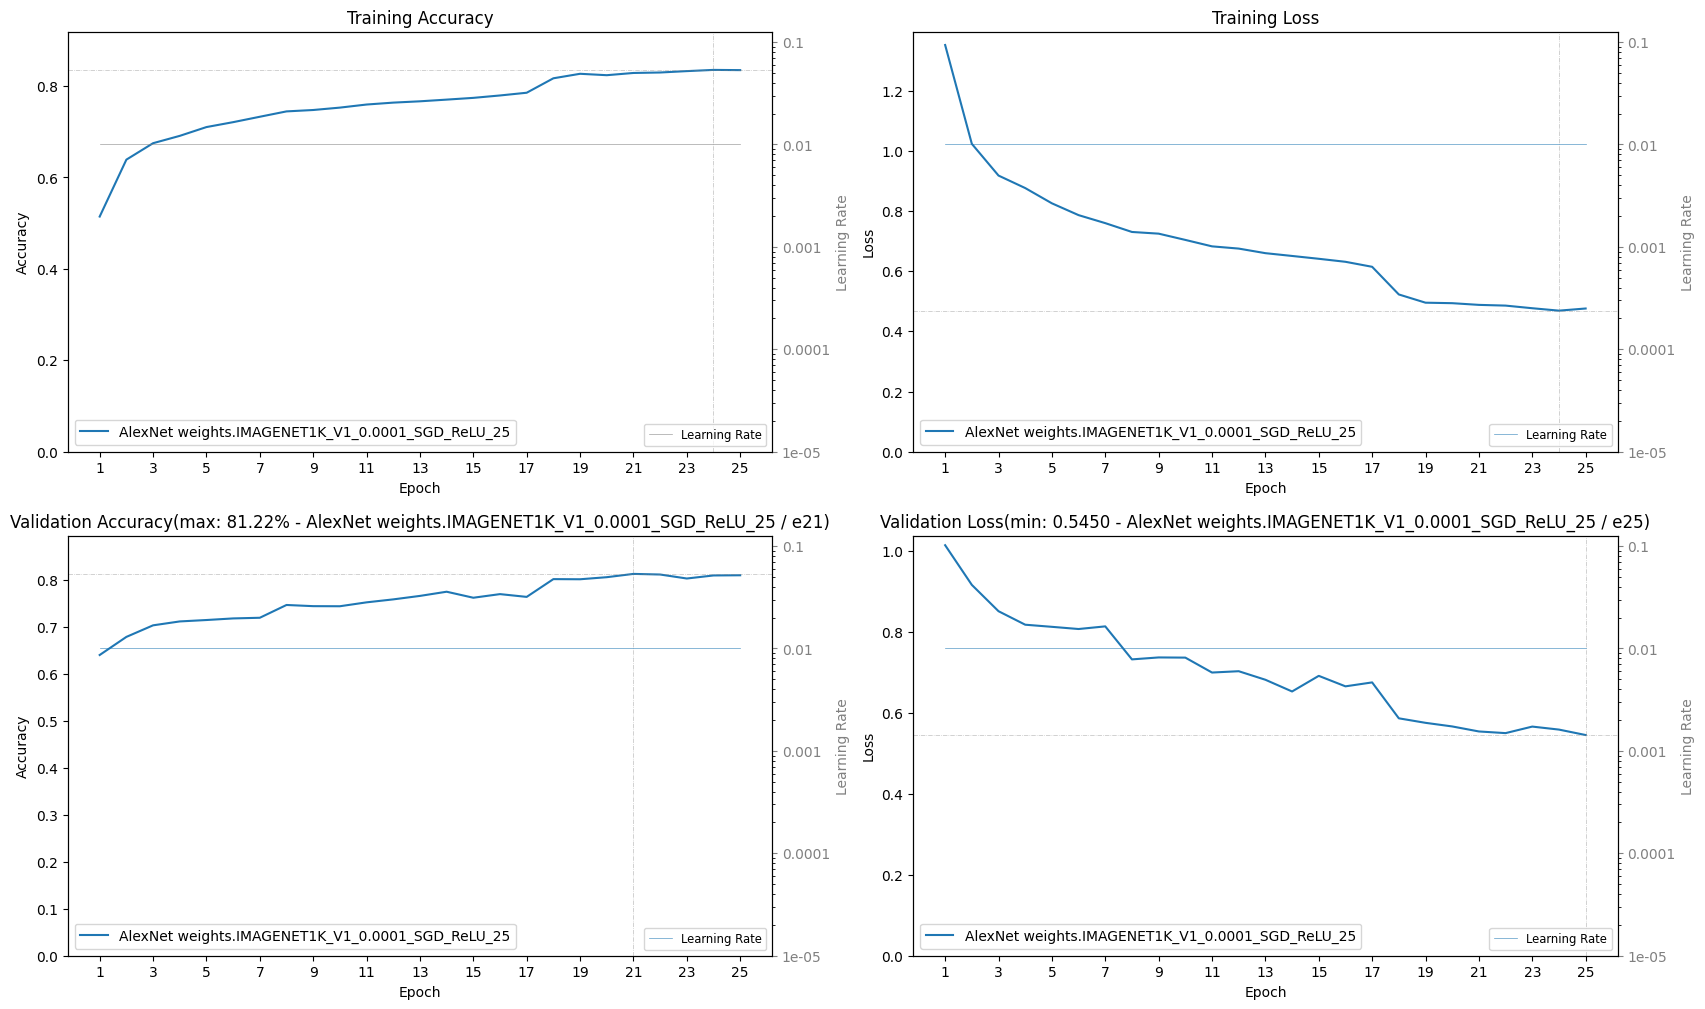

In [ ]:
plot_metrics()

Testing progress:   0%|          | 0/79 [00:00<?, ?it/s]

                           Test accuracy: 91.21%


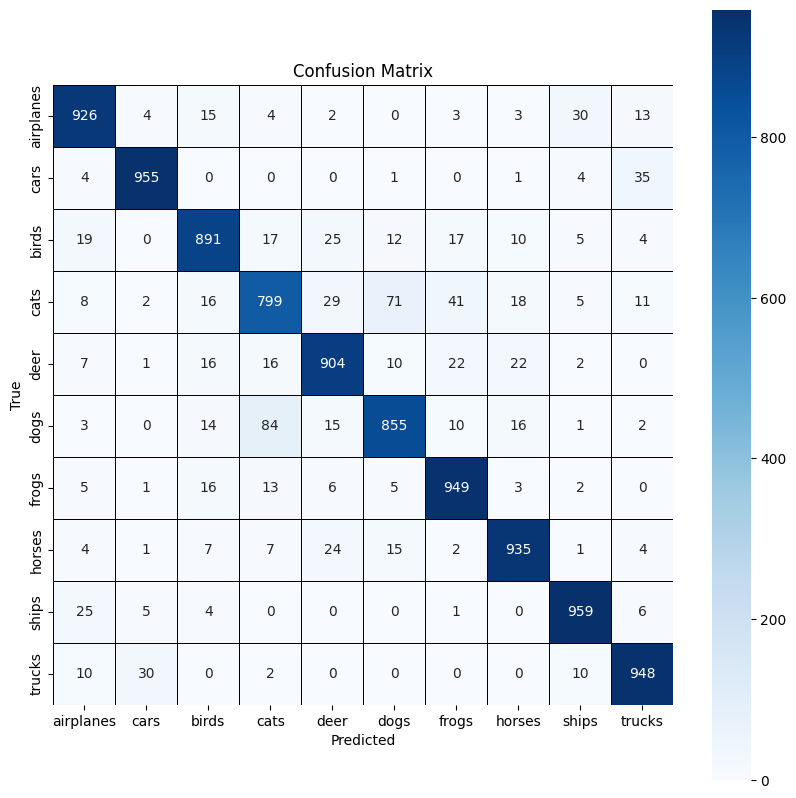

Classification Report:

              precision    recall  f1-score   support

   airplanes       0.92      0.93      0.92      1000
        cars       0.96      0.95      0.96      1000
       birds       0.91      0.89      0.90      1000
        cats       0.85      0.80      0.82      1000
        deer       0.90      0.90      0.90      1000
        dogs       0.88      0.85      0.87      1000
       frogs       0.91      0.95      0.93      1000
      horses       0.93      0.94      0.93      1000
       ships       0.94      0.96      0.95      1000
      trucks       0.93      0.95      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

tensor([[3.2802e-09, 9.6122e-10, 2.9562e-07,  ..., 2.5873e-08, 8.2510e-11,
         2.8641e-10],
        [6.4678e-04, 1.7659e-03, 3.1089e-09,  ..., 8.0707e-10, 9.9759e-01,
         1.5884e-06],
        [6.5017e-05, 4.

In [ ]:
# Testing the best model
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# Load the saved model
model_path = os.path.join(mount_point, project_folder, f'best_model.pth')

# Set the model to evaluation mode
model = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
model.to(device)
inputs = inputs.to(device)
labels = labels.to(device)

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(class_names))
model.eval()

# Load the model weights
if device.type == 'cuda':
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

all_preds = []
all_labels = []

softmax_scores = []
image_names = []

test_progress_bar = tqdm(dataloaders['test'], desc='Testing progress')

for inputs, labels, paths in test_progress_bar:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():

        outputs = model(inputs)
        softmax = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    softmax_scores.append(softmax.cpu())

    image_names.extend([p.item() for p in paths.flatten()])  # Convert tensor to string and flatten

    # Update progress bar
    test_progress_bar.set_postfix(acc=torch.sum(preds == labels.data))

accuracy = accuracy_score(all_labels, all_preds)
print(f'                           Test accuracy: {accuracy * 100:.2f}%')

softmax_scores = torch.cat(softmax_scores)
#image_names = [os.path.splitext(os.path.basename(p))[0] for p in image_names]

# Plotting confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, linewidths=0.5, linecolor='black', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report:\n')
print(report)

print(softmax_scores)

# Saving softmax scores
softmax_scores_path = os.path.join(mount_point, project_folder, softmax_folder, 'softmax_scores.npy')

if not os.path.exists(softmax_scores_path):
    np.save(softmax_scores_path, softmax_scores)
    print(f'\nSoftmax scores saved to {softmax_scores_path}')
else:
    print(f'\nSoftmax scores already stored in {softmax_scores_path}')

In [ ]:
#%tensorboard --logdir {os.path.join(mount_point, project_folder, 'logs')}
#tensorboard_process.terminate()
#tensorboard_process.wait()